In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics, svm
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

from xgboost import XGBRegressor

<h1>Configuration</h1>

In [39]:
random_state = 42
path_to_dataset = "winters_merged.csv"
index_col = "ts"
target_variable = "Friction"
# Test/train split size
test_size = 0.3

# KNN max iterations 
# adjust this to 50 or even 150 if you have lots of data rows
max_iterations = 20

<h1>Dataset loading</h1>

In [40]:
# Loads dataset from file
# Provide index_col in order to avoid spawning of index column "Unnamed: 0"
df = pd.read_csv(path_to_dataset, index_col=index_col)

# initialize DF for saving metrics
metrics_df = pd.DataFrame({
    'Metric': ['Mean Squared Error', 'Root Mean Squared Error', 'Mean Absolute Error', 'R-squared']})
df.head()

,airTemp,humidity,dewpoint,precipitation,Friction,Road_Surface_Temperature,Water_Film_Surface_mm
ts,,,,,,,
2021-11-01 00:00:00,8.8,94.0,7.9,0.0,0.82,5.082435,0.0
2021-11-01 00:10:00,9.1,91.0,7.7,0.0,0.82,5.035252,0.0
2021-11-01 00:20:00,9.1,90.0,7.5,0.0,0.82,4.951386,0.0
2021-11-01 00:30:00,9.2,88.0,7.3,0.0,0.82,5.077870,0.0
2021-11-01 00:40:00,9.2,86.0,7.0,0.0,0.82,4.919721,0.0


<h1>Split the dataset</h1>

In [41]:
# First, split to X (data, all features except target variable) and y (only target variable)
X = df.drop([target_variable], axis=1)
y = df[target_variable]
# Then split to train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)


<h1>Models</h1>

<table>
    <tr>
        <th>Algorithm</th>
        <th>Pros</th>
        <th>Cons</th>
        <th>Data requirements</th>
    </tr>
    <tr>
        <th>Linear regression</th>
        <th>Simple and easy to interpret</th>
        <th>Sensitive to outliers</th>
        <th>• Requires linear relationship between variables
            • Independent data points
            • Normal distribution
            • Constant variance between data and
            predictions
        </th>
    </tr>
    <tr>
        <th>Support Vector Machines (SVM)</th>
        <th>Effective in high-dimensional spaces (high number of columns)</th>
        <th>• Can be slow and memory-intensive for large datasets (amount of rows)
        • Computationally intensive
        • Optimization can be tedious</th>
        <th>Data scaling required</th>
    </tr>
    <tr>
        <th>Random forests</th>
        <th>Handles non-linear relationships well</th>
        <th>• Can overfit with noisy and overlapping data
            • Can be slow for real-time prediction</th>
        <th>Less preprocessing, handles missing values well</th>
    </tr>
    <tr>
        <th>KNN</th>
        <th>Simple and easy to understand</th>
        <th>• Computationally expensive for large datasets
            • Sensitive to irrelevant variables
            • Prediction can be slow for large datasets</th>
        <th>Data balance is important (equal representation for each output class)</th>
    </tr>
</table>

<h3>Linear Regression</h3>

In [42]:
lm = LinearRegression()
lm.fit(X_train, y_train)
predictions = lm.predict(X_test)

In [43]:
# MAE - Mean average error
mae = round(metrics.mean_absolute_error(y_test, predictions), 2)
# MSE - Mean square error
mse = round(metrics.mean_squared_error(y_test, predictions), 2)
# RMSE - Root mean square error
rmse = round(np.sqrt(metrics.mean_squared_error(y_test, predictions)), 2)
# R-squared. 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
r2 = round(metrics.r2_score(y_test, predictions), 2)

metrics_df["LinearReg"] = [mse, rmse, mae, r2]
metrics_df

,Metric,LinearReg
0,Mean Squared Error,0.02
1,Root Mean Squared Error,0.14
2,Mean Absolute Error,0.11
3,R-squared,0.32


<h3>SVM</h3>

In [44]:
df_scaled = df.copy()

In [45]:
# initalize scaler
scalerY = MinMaxScaler()

# save min/max -values of target value
# for bettermetrics later
min_y = df_scaled[target_variable].min()
max_y = df_scaled[target_variable].max()

# scale y-variable
num_vars = [target_variable]
df_scaled[num_vars] = scalerY.fit_transform(df_scaled[num_vars])

In [46]:
# First, split to X (data, all features except target variable) and y (only target variable)
X_scaled = df_scaled.drop([target_variable], axis=1)
y_scaled = df_scaled[target_variable]
# Then split to train and test data
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=test_size, random_state=random_state)


In [47]:
# connect standard scaler for X-values
# you can also use MinMaxScaler() if performance is not good enough
model = make_pipeline(StandardScaler(), svm.SVR())
model.fit(X_train_scaled, y_train_scaled)

predictions = model.predict(X_test_scaled)

In [48]:
# MAE - Mean average error
mae = round(metrics.mean_absolute_error(y_test_scaled, predictions), 3)
# MSE - Mean square error
mse = round(metrics.mean_squared_error(y_test_scaled, predictions), 3)
# RMSE - Root mean square error
rmse = round(metrics.root_mean_squared_error(y_test_scaled, predictions), 2)

# R-squared. 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
r2 = round(metrics.r2_score(y_test_scaled, predictions), 3)

metrics_df['LinearSVR'] = [mse, rmse, mae, r2]
metrics_df

,Metric,LinearReg,LinearSVR
0,Mean Squared Error,0.02,0.009
1,Root Mean Squared Error,0.14,0.090
2,Mean Absolute Error,0.11,0.071
3,R-squared,0.32,0.845


<h3>Random forests</h3>


In [49]:
model = make_pipeline(StandardScaler(), RandomForestRegressor())
model.fit(X_train, y_train)
predictions = model.predict(X_test)

In [50]:
mse = round(metrics.mean_squared_error(y_test, predictions), 2)
rmse = round(metrics.root_mean_squared_error(y_test, predictions), 2)
mae = round(metrics.mean_absolute_error(y_test, predictions), 2)
r2 = round(metrics.r2_score(y_test, predictions), 2)

metrics_df["Random forest"] = [mse, rmse, mae, r2]
metrics_df

,Metric,LinearReg,LinearSVR,Random forest
0,Mean Squared Error,0.02,0.009,0.00
1,Root Mean Squared Error,0.14,0.090,0.04
2,Mean Absolute Error,0.11,0.071,0.01
3,R-squared,0.32,0.845,0.96


<h3>XGB<h3>

In [51]:
model = XGBRegressor(random_state=random_state)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

In [52]:
mse = round(metrics.mean_squared_error(y_test, predictions), 2)
rmse = round(metrics.root_mean_squared_error(y_test, predictions), 2)
mae = round(metrics.mean_absolute_error(y_test, predictions), 2)
r2 = round(metrics.r2_score(y_test, predictions), 2)

metrics_df["XGB"] = [mse, rmse, mae, r2]
metrics_df

,Metric,LinearReg,LinearSVR,Random forest,XGB
0,Mean Squared Error,0.02,0.009,0.00,0.00
1,Root Mean Squared Error,0.14,0.090,0.04,0.04
2,Mean Absolute Error,0.11,0.071,0.01,0.02
3,R-squared,0.32,0.845,0.96,0.94


<h3>KNN</h3>

Based on iterations, best k-value is this:
3


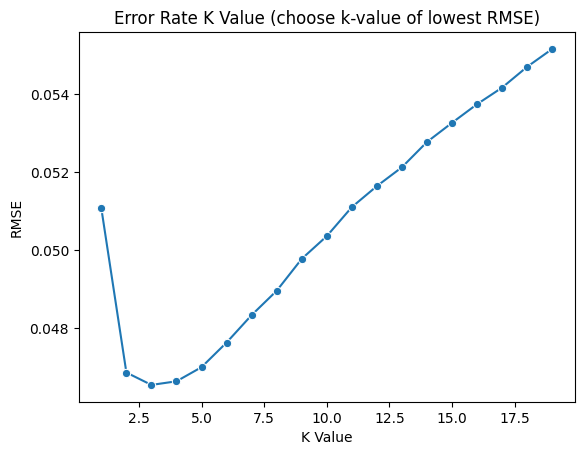

In [53]:
# list to save the error values in the loop
error = []

# the default metric in scikit-learn
metric_selection = "minkowski"

# Calculating error for K values between 1 and 40
for i in range(1, max_iterations):

    # try with current k-value, train the model and make a test prediction
    knn = make_pipeline(StandardScaler(), KNeighborsRegressor(n_neighbors=i, metric=metric_selection))
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    
    # save the error value for this k-value
    error.append(np.sqrt(metrics.mean_squared_error(y_test, pred_i)))
    
# plot all the k-values and their error values
sns.lineplot(x=range(1, max_iterations), y=error, marker='o')
plt.title('Error Rate K Value (choose k-value of lowest RMSE)')
plt.xlabel('K Value')
plt.ylabel('RMSE')

# choose best k-value based on metrics
# we have to add +1 to k-value, since argmin() returns an index
# which starts from 0, but k-values start from 1
print("Based on iterations, best k-value is this:")
k_value = np.argmin(error) + 1
print(k_value)

# build the model with the optimal values
model = make_pipeline(StandardScaler(), KNeighborsRegressor(n_neighbors=k_value, metric=metric_selection))
model.fit(X_train, y_train)
predictions = model.predict(X_test)

In [54]:
mse = round(metrics.mean_squared_error(y_test, predictions), 2)
rmse = round(metrics.root_mean_squared_error(y_test, predictions), 2)
mae = round(metrics.mean_absolute_error(y_test, predictions), 2)
r2 = round(metrics.r2_score(y_test, predictions), 2)

metrics_df["KNN"] = [mse, rmse, mae, r2]
metrics_df

,Metric,LinearReg,LinearSVR,Random forest,XGB,KNN
0,Mean Squared Error,0.02,0.009,0.00,0.00,0.00
1,Root Mean Squared Error,0.14,0.090,0.04,0.04,0.05
2,Mean Absolute Error,0.11,0.071,0.01,0.02,0.02
3,R-squared,0.32,0.845,0.96,0.94,0.93
